In [2]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 18.8 MB/s 
     |████████████████████████████████| 7.6 MB 23.5 MB/s 
     |████████████████████████████████| 182 kB 62.3 MB/s 


In [1]:
from transformers import BertTokenizer, BertModel,BertForMaskedLM

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import nn
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
# % matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
epochs=4

In [5]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

Saving in_domain_dev.tsv to in_domain_dev (2).tsv
Saving in_domain_train.tsv to in_domain_train (2).tsv
Saving out_of_domain_dev.tsv to out_of_domain_dev (2).tsv


In [6]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [7]:
basemodel = BertForMaskedLM.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
MAX_LEN = 128

In [9]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [10]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [11]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def accuracyfn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_true)*100
  return acc

Generation module

In [12]:
gen_labels = np.copy(input_ids)
# gen_labels = input_ids.detach().clone()

In [13]:
rand= torch.rand(input_ids.shape)
gen_mask = (rand < 0.15) * (input_ids != 101) * (input_ids != 102) * (input_ids != 0)

#selection of true values from genmask
selection = []

for i in range(input_ids.shape[0]):
    selection.append(
        torch.flatten(gen_mask[i].nonzero()).tolist()
    )
for i in range(input_ids.shape[0]):
    input_ids[i, selection[i]] = 103

In [14]:
gen_labels = torch.tensor(gen_labels)

In [15]:
gtrain_inputs, gvalidation_inputs, gtrain_labels, gvalidation_labels = train_test_split(input_ids, gen_labels, 
                                                            random_state=2018, test_size=0.1)
gtrain_masks, gvalidation_masks, _, _ = train_test_split(gen_mask, input_ids,
                                             random_state=2018, test_size=0.1)

In [16]:
gtrain_inputs = torch.tensor(gtrain_inputs)
gvalidation_inputs = torch.tensor(gvalidation_inputs)
gtrain_labels = torch.tensor(gtrain_labels)
gvalidation_labels = torch.tensor(gvalidation_labels)
gtrain_masks = torch.tensor(gtrain_masks)
gvalidation_masks = torch.tensor(gvalidation_masks)

<ipython-input-16-86cc1001e6a6>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gtrain_labels = torch.tensor(gtrain_labels)
<ipython-input-16-86cc1001e6a6>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gvalidation_labels = torch.tensor(gvalidation_labels)
<ipython-input-16-86cc1001e6a6>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gtrain_masks = torch.tensor(gtrain_masks)
<ipython-input-16-86cc1001e6a6>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().d

In [17]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

gtrain_data = TensorDataset(gtrain_inputs, gtrain_masks, gtrain_labels)
gtrain_sampler = RandomSampler(gtrain_data)
gtrain_dataloader = DataLoader(gtrain_data, sampler=gtrain_sampler, batch_size=batch_size)

gvalidation_data = TensorDataset(gvalidation_inputs, gvalidation_masks, gvalidation_labels)
gvalidation_sampler = SequentialSampler(gvalidation_data)
gvalidation_dataloader = DataLoader(gvalidation_data, sampler=gvalidation_sampler, batch_size=batch_size)

In [18]:
# genmodel = BertForMaskedLM.from_pretrained('bert-base-uncased')
genmodel = basemodel
genmodel.to(device)
genmodel.train()
genoptim = torch.optim.Adam(filter(lambda p: p.requires_grad, genmodel.parameters()))

In [19]:
lossfn = nn.L1Loss()

In [20]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 1

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  genmodel.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(gtrain_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    genoptim.zero_grad()
    # Forward pass
    # print("training loop forward pass hsapes in treatment group= ",b_input_ids.shape, b_input_mask.shape, b_labels.shape)
    outputs = genmodel(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    # outputs = genmodel(b_input_ids, attention_mask=b_input_mask)
    # outputs = nn.LogSoftmax(dim=1)(outputs)
    # loss = criterion(outputs, b_labels)   
    # print("outputs= ",outputs[0][0])
    # print("labels = ",b_labels[0])
    # out = outputs[0][:,:,0]
    # print("out type= ",out.dtype, b_labels.dtype)
    loss = outputs.loss
    # loss = lossfn(out, b_labels.float())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    # optimizer.step()
    # loss.backward()
    genoptim.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    train_loss_set.append(loss.item())
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  genmodel.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # # Evaluate data for one epoch
  # for batch in gvalidation_dataloader:
  #   # Add batch to GPU
  #   batch = tuple(t.to(device) for t in batch)
  #   # Unpack the inputs from our dataloader
  #   b_input_ids, b_input_mask, b_labels = batch
  #   # Telling the model not to compute or store gradients, saving memory and speeding up validation
  #   with torch.no_grad():
  #     # Forward pass, calculate logit predictions
  #     # print("shape= ",b_input_ids.shape,b_input_mask.shape,b_labels.shape)
  #     # logits = genmodel(b_input_ids, attention_mask=b_input_mask,
  #     #                   labels=labels)
  #     outputs = genmodel(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
  #     # outputs = genmodel(b_input_ids, attention_mask=b_input_mask)
  #     # logits = outputs[0][:,:,0]
  #     logits = outputs.logits
    
  #   # Move logits and labels to CPU
  #   # print(logits)
  #   logits = logits.cpu().numpy()
  #   label_ids = b_labels.cpu().numpy()
  #   # print("shapes= ",logits.shape, label_ids.shape)
  #   # print(logits[0:5], label_ids[0:5])
  #   tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
  #   eval_accuracy += tmp_eval_accuracy
  #   nb_eval_steps += 1
  #   # hidden.detach_()
  #   # hidden = hidden.detach()

  # print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch: 100%|██████████| 1/1 [03:12<00:00, 192.85s/it]

Train loss: 1.0147111658238772


##Control group

In [36]:
df = pd.read_csv("in_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [38]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [39]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [41]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

<ipython-input-41-42a06c90195a>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
<ipython-input-41-42a06c90195a>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_inputs)
<ipython-input-41-42a06c90195a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
<ipython-input-41-42a06c90195a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detac

In [42]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [21]:
class CustomBERTModel(nn.Module):
    def __init__(self):
          super(CustomBERTModel, self).__init__()
          self.bert = genmodel
          ### New layers:
          self.linear1 = nn.Linear(30522, 256)
          self.linear2 = nn.Linear(256, 1) ## 3 is the number of classes in this example

    def forward(self, ids, mask, labels):
          # print("ids= ",ids.shape, "mask= ",mask.shape, "labels=",labels.shape)
          # print("self.bert = ",self.bert)
          # sequence_output, pooled_output = self.bert(
          #      ids, 
          #      attention_mask=mask)
          sequence_output = self.bert(
               ids, 
               attention_mask=mask, labels=labels)
          # print("a= ",len(a))
          # sequence_output, pooled_output = a[0], a[1]
          # sequence_output has the following shape: (batch_size, sequence_length, 768)
          # print("sequence_output shape=",sequence_output.shape)
          # print("pooled op shape=",pooled_output.shape)
          linear1_output = self.linear1(sequence_output.logits) ## extract the 1st token's embeddings

          linear2_output = self.linear2(linear1_output)

          return linear2_output

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = CustomBERTModel() # You can pass the parameters if required to have more flexible model
model.to(torch.device(device)) ## can be gpu
criterion = nn.BCEWithLogitsLoss() ## If required define your own criterion
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

# for epoch in range(epochs):
#     for batch in data_loader: ## If you have a DataLoader()  object to get the data.

#         data = batch[0]
#         targets = batch[1] ## assuming that data loader returns a tuple of data and its targets
        
#         optimizer.zero_grad()   
#         encoding = tokenizer.batch_encode_plus(data, return_tensors='pt', padding=True, truncation=True,max_length=50, add_special_tokens = True)
#         outputs = model(input_ids, attention_mask=attention_mask)
#         outputs = F.log_softmax(outputs, dim=1)
#         input_ids = encoding['input_ids']
#         attention_mask = encoding['attention_mask']
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

In [44]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 1

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    # print("training loop forward pass hsapes= ",b_input_ids.shape, b_input_mask.shape, b_labels.shape)
    # print()
    # print()
    # print()
    outputs = model(b_input_ids, mask=b_input_mask, labels=b_input_ids.detach().clone()).squeeze()
    # print("outputs before=",outputs.shape)
    # outputs=outputs[0]
    outputs = outputs[:,0]
    # outputs = nn.LogSoftmax(dim=0)(outputs)
    # outputs = outputs.squeeze()
    out = torch.round(torch.sigmoid(outputs))
    # print("out=",out[0], "blabels=",b_labels.shape)
    loss = criterion(out, b_labels.float())   
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    # optimizer.step()
    # loss.backward()
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    train_loss_set.append(loss.item())
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      # print("shape= ",b_input_ids.shape,b_input_mask.shape,b_labels.shape)
      logits = model(b_input_ids, mask=b_input_mask, labels=b_input_ids.detach().clone()).squeeze()
      logits = logits[:,0]
      logits = torch.round(torch.sigmoid(logits))
    
    # Move logits and labels to CPU
    # logits = logits.detach().cpu().numpy()
    # label_ids = b_labels.cpu().numpy()

    tmp_eval_accuracy = accuracyfn(logits, b_labels)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
    # hidden.detach_()
    # hidden = hidden.detach()

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.6931471864382426


Epoch: 100%|██████████| 1/1 [00:11<00:00, 11.94s/it]

Validation Accuracy: 29.166666666666664


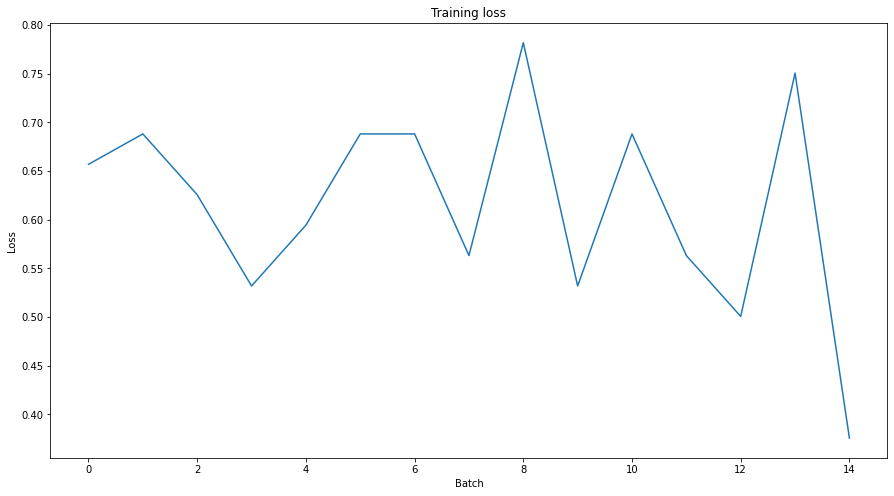

In [30]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Testing


In [30]:
# Upload the test file from your local drive
from google.colab import files
uploaded = files.upload()

Saving out_of_domain_dev.tsv to out_of_domain_dev.tsv


In [22]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  # print("seq=",seq)
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32 


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [23]:
# Prediction on test set
testmodel = model
# Put model in evaluation mode
testmodel.eval()

# Tracking variables 
predictions , true_labels = [], []

test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    # print("b_input_ids.shape= ",b_input_ids.shape)
    # print("b_input_mask.shape= ",b_input_mask.shape)
    logits = testmodel(b_input_ids, mask=b_input_mask, labels=b_input_ids.detach().clone()).squeeze()
    logits = logits[:,0]
    logits = torch.round(torch.sigmoid(logits))

  # Move logits and labels to CPU
  # logits = logits.detach().cpu().numpy()
  # label_ids = b_labels.to('cpu').numpy()

  tmp_test_accuracy = accuracyfn(logits, b_labels)
  test_accuracy += tmp_test_accuracy
  nb_test_steps += 1

  
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(b_labels)

print("Test Accuracy: {}".format(test_accuracy/nb_test_steps))

Test Accuracy: 31.066176470588236
